# LANE DETECTION
by  
**P S Karthik , AM.EN.U4CSE18509**  
**G Dhanush , AM.EN.U4CSE18321**  
**G Meghana , AM.EN.U4CSE18319**  

### Importing libraries

In [1]:
import os
import re
import cv2
import math
import numpy as np
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from scipy import linspace, polyval, polyfit, sqrt, stats, randn, stats

In [2]:
# get file names of frames
col_frames = os.listdir('dataset1/')
col_frames.sort(key=lambda f: int(re.sub('\D', '', f)))

# load frames
col_images=[]
for i in tqdm_notebook(col_frames):
    img = cv2.imread('dataset1/'+i)
    col_images.append(img)

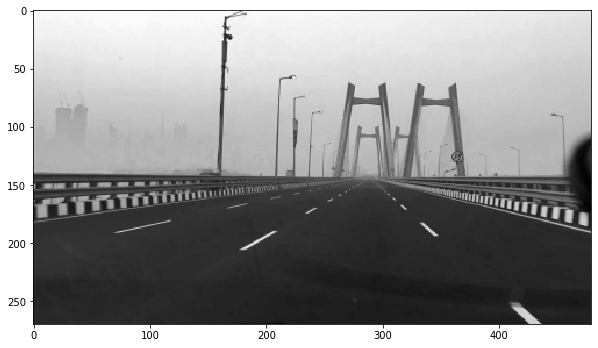

In [3]:
# specify frame index
idx = 200

# plot frame
plt.figure(figsize=(10,10))
plt.imshow(col_images[idx][:,:,0], cmap= "gray")
plt.show()

### Gaussian Blur

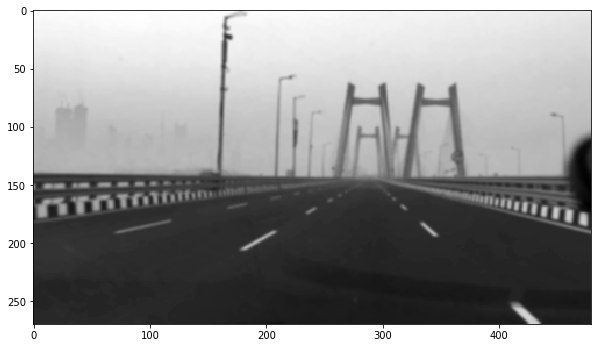

In [4]:
img = col_images[idx][:,:,0]
blur_gray = cv2.GaussianBlur(img, (5, 5), 0)
plt.figure(figsize=(10,10))
plt.imshow(blur_gray, cmap= "gray")
plt.show()

### Canny Edge Detection

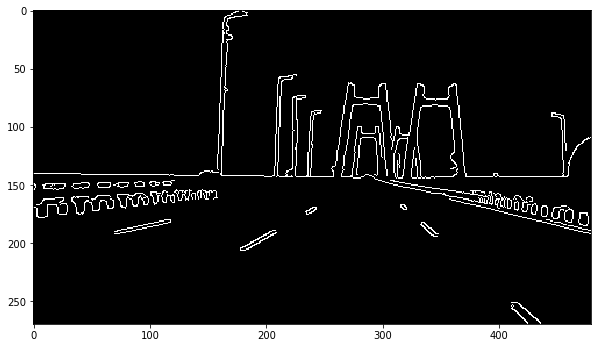

In [5]:
low_threshold = 10
high_threshold = 200
canimg = cv2.Canny(blur_gray, low_threshold, high_threshold)
plt.figure(figsize=(10,10))
plt.imshow(canimg, cmap= "gray")
plt.show()

### Frame Mask Creation

In [6]:
# create a zero array
img = col_images[idx][:,:,0]
stencil = np.zeros_like(canimg)

# specify coordinates of the polygon
# For frames:
polygon = np.array([[50,270], [220,160], [360,160], [480,270]])
# For frames2:
#polygon = np.array([[100,550], [400,250], [600,250], [950,550]])

# fill polygon with ones
cv2.fillConvexPoly(stencil, polygon, 1)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 1, 1, 0],
       [0, 0, 0, ..., 1, 1, 1]], dtype=uint8)

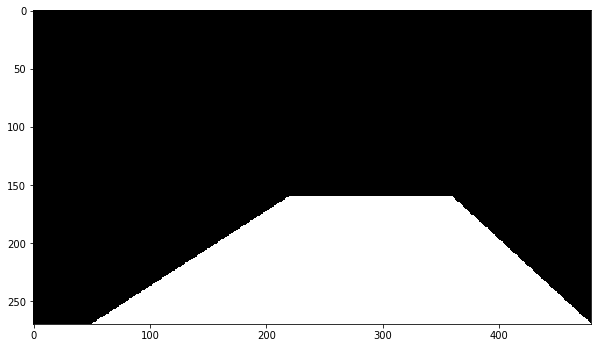

In [7]:
# plot polygon
plt.figure(figsize=(10,10))
plt.imshow(stencil, cmap= "gray")
plt.show()

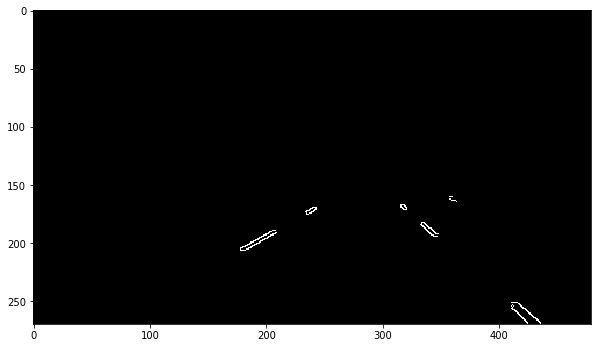

In [8]:
# apply polygon as a mask on the frame
img1 = cv2.bitwise_and(canimg, canimg, mask=stencil)

# plot masked frame
plt.figure(figsize=(10,10))
plt.imshow(img1, cmap= "gray")
plt.show()

## Image Pre-processing  
### 1. Image Thresholding

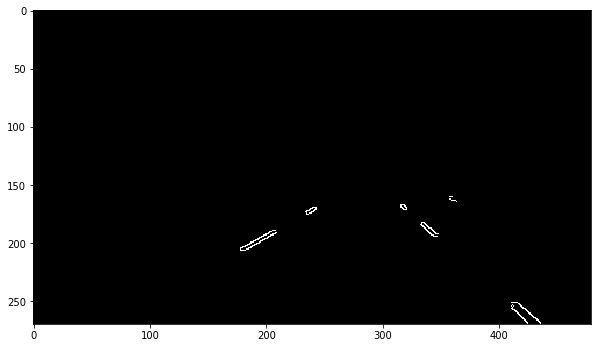

In [9]:
# apply image thresholding
ret, thresh = cv2.threshold(img1, 130, 145, cv2.THRESH_BINARY)

# plot image
plt.figure(figsize=(10,10))
plt.imshow(thresh, cmap= "gray")
plt.show()

### 2. Hough Line Transformation

In [10]:
def perp( a ) :
    b = np.empty_like(a)
    b[0] = -a[1]
    b[1] = a[0]
    return b
def seg_intersect(a1,a2, b1,b2):
    da = a2-a1
    db = b2-b1
    dp = a1-b1
    dap = perp(da)
    denom = np.dot( dap, db)
    num = np.dot( dap, dp )
    return (num / denom.astype(float))*db + b1

def movingAverage(avg, new_sample, N=20):
    if (avg == 0):
        return new_sample
    avg -= avg / N;
    avg += new_sample / N;
    return avg;

In [11]:
def draw_lines_avg(img, lines, color=[0, 255, 0], thickness=5):
   # state variables to keep track of most dominant segment
    avgLeft = (0,0,0,0)
    avgRight = (0,0,0,0)
    largestLeftLineSize = 0
    largestRightLineSize = 0
    largestLeftLine = (0,0,0,0)
    largestRightLine = (0,0,0,0)

    if lines is None:
        avgx1, avgy1, avgx2, avgy2 = avgLeft
        cv2.line(img, (int(avgx1), int(avgy1)), (int(avgx2), int(avgy2)), [0,255,0], thickness) #draw left line
        avgx1, avgy1, avgx2, avgy2 = avgRight
        cv2.line(img, (int(avgx1), int(avgy1)), (int(avgx2), int(avgy2)), [0,255,0], thickness) #draw right line
        return
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            size = math.hypot(x2 - x1, y2 - y1)
            slope = ((y2-y1)/(x2-x1))
            # Filter slope based on incline and
            # find the most dominent segment based on length
            if (slope > 0.5): #right
                if (size > largestRightLineSize):
                    largestRightLine = (x1, y1, x2, y2)                    
                cv2.line(img, (x1, y1), (x2, y2), color, thickness)
            elif (slope < -0.5): #left
                if (size > largestLeftLineSize):
                    largestLeftLine = (x1, y1, x2, y2)
                cv2.line(img, (x1, y1), (x2, y2), color, thickness)

    # Define an imaginary horizontal line in the center of the screen
    # and at the bottom of the image, to extrapolate determined segment
    imgHeight, imgWidth = (img.shape[0], img.shape[1])
    upLinePoint1 = np.array( [0, int(imgHeight - (imgHeight/3))] )
    upLinePoint2 = np.array( [int(imgWidth), int(imgHeight - (imgHeight/3))] )
    downLinePoint1 = np.array( [0, int(imgHeight)] )
    downLinePoint2 = np.array( [int(imgWidth), int(imgHeight)] )
    
    # Find the intersection of dominant lane with an imaginary horizontal line
    # in the middle of the image and at the bottom of the image.
    p3 = np.array( [largestLeftLine[0], largestLeftLine[1]] )
    p4 = np.array( [largestLeftLine[2], largestLeftLine[3]] )
    upLeftPoint = seg_intersect(upLinePoint1,upLinePoint2, p3,p4)
    downLeftPoint = seg_intersect(downLinePoint1,downLinePoint2, p3,p4)
    avgLeft = (0,0,0,0)
    avgRight = (0,0,0,0)
    if (math.isnan(upLeftPoint[0]) or math.isnan(downLeftPoint[0])):
        avgx1, avgy1, avgx2, avgy2 = avgLeft
        cv2.line(img, (int(avgx1), int(avgy1)), (int(avgx2), int(avgy2)), [0,255,0], thickness) #draw left line
        avgx1, avgy1, avgx2, avgy2 = avgRight
        cv2.line(img, (int(avgx1), int(avgy1)), (int(avgx2), int(avgy2)), [0,255,0], thickness) #draw right line
        return
    cv2.line(img, (int(upLeftPoint[0]), int(upLeftPoint[1])), (int(downLeftPoint[0]), int(downLeftPoint[1])), [0, 255, 0], thickness) #draw left line

    # Calculate the average position of detected left lane over multiple video frames and draw
    avgx1, avgy1, avgx2, avgy2 = avgLeft
    avgLeft = (movingAverage(avgx1, upLeftPoint[0]), movingAverage(avgy1, upLeftPoint[1]), movingAverage(avgx2, downLeftPoint[0]), movingAverage(avgy2, downLeftPoint[1]))
    avgx1, avgy1, avgx2, avgy2 = avgLeft
    cv2.line(img, (int(avgx1), int(avgy1)), (int(avgx2), int(avgy2)), [0,255,0], thickness) #draw left line

    # Find the intersection of dominant lane with an imaginary horizontal line
    # in the middle of the image and at the bottom of the image.
    p5 = np.array( [largestRightLine[0], largestRightLine[1]] )
    p6 = np.array( [largestRightLine[2], largestRightLine[3]] )
    upRightPoint = seg_intersect(upLinePoint1,upLinePoint2, p5,p6)
    downRightPoint = seg_intersect(downLinePoint1,downLinePoint2, p5,p6)
    if (math.isnan(upRightPoint[0]) or math.isnan(downRightPoint[0])):
        avgx1, avgy1, avgx2, avgy2 = avgLeft
        cv2.line(img, (int(avgx1), int(avgy1)), (int(avgx2), int(avgy2)), [0,255,0], thickness) #draw left line
        avgx1, avgy1, avgx2, avgy2 = avgRight
        cv2.line(img, (int(avgx1), int(avgy1)), (int(avgx2), int(avgy2)), [0,255,0], thickness) #draw right line
        return
    cv2.line(img, (int(upRightPoint[0]), int(upRightPoint[1])), (int(downRightPoint[0]), int(downRightPoint[1])), [0, 255, 0], thickness) #draw left line

    # Calculate the average position of detected right lane over multiple video frames and draw
    avgx1, avgy1, avgx2, avgy2 = avgRight
    avgRight = (movingAverage(avgx1, upRightPoint[0]), movingAverage(avgy1, upRightPoint[1]), movingAverage(avgx2, downRightPoint[0]), movingAverage(avgy2, downRightPoint[1]))
    avgx1, avgy1, avgx2, avgy2 = avgRight
    cv2.line(img, (int(avgx1), int(avgy1)), (int(avgx2), int(avgy2)), [0,255,0], thickness) #draw left line

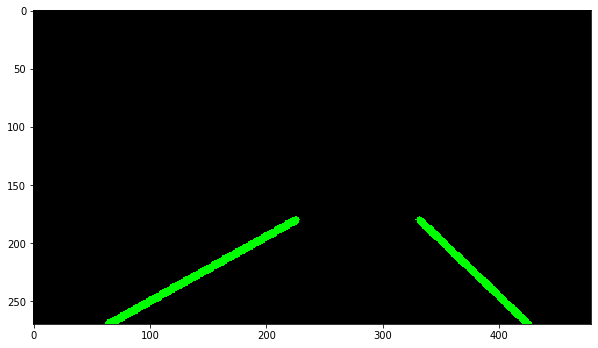

In [12]:
lines = cv2.HoughLinesP(thresh, 1, np.pi/180, 30, maxLineGap=200)
y_margin = 0.6
# create a copy of the original frame
dmy = col_images[idx][:,:,0].copy()
line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
draw_lines_avg(line_img, lines, y_margin)
#draw Hough lines
#for line in lines:
  #x1, y1, x2, y2 = line[0]
  #cv2.line(dmy, (x1, y1), (x2, y2), (0, 255, 0), 3)

# plot frame
plt.figure(figsize=(10,10))
plt.imshow(line_img, cmap= "gray")
plt.show()

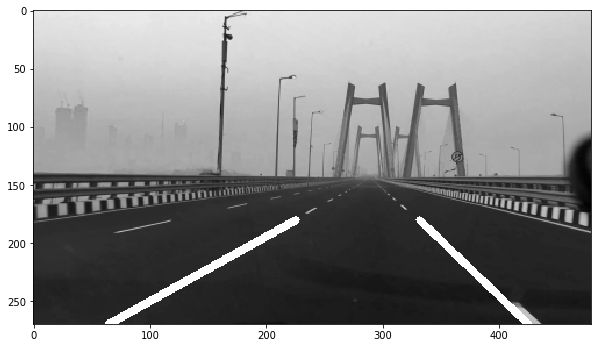

In [13]:
line_edges = cv2.addWeighted(img, 1, line_img[:,:,1], 1,0)
plt.figure(figsize=(10,10))
plt.imshow(line_edges, cmap= "gray")
plt.show()

In [14]:
cnt = 0
for frame in tqdm_notebook(col_images):
    # Apply gaussian blur with kernel size = 5
    blur_gray = cv2.GaussianBlur(frame[:,:,0], (5, 5), 0)
    #Canny edge detection
    canimg = cv2.Canny(blur_gray, low_threshold, high_threshold)
    # apply frame mask
    masked = cv2.bitwise_and(canimg, canimg, mask=stencil)
        # apply image thresholding
    ret1, thresh22 = cv2.threshold(masked, 130, 145, cv2.THRESH_BINARY)
    # apply Hough Line Transformation
    lines1 = cv2.HoughLinesP(thresh22, 1, np.pi/180, 30, maxLineGap=200)
    dmy1 = frame.copy()

    # Plot detected lines
    try:
        #for line in lines:
        #x1, y1, x2, y2 = line[0]
        #cv2.line(dmy, (x1, y1), (x2, y2), (255, 0, 0), 3)
        line_img1 = np.zeros((dmy1.shape[0], dmy1.shape[1], 3), dtype=np.uint8)
        draw_lines_avg(line_img1, lines1, y_margin)
        line_edges = cv2.addWeighted(frame, 1, line_img1, 1,0)
        cv2.imwrite('detected1/'+str(cnt)+'.png',line_edges)
    except TypeError: 
        cv2.imwrite('detected1/'+str(cnt)+'.png',frame)
    cnt+=1

C:\Users\91891\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in true_divide
  del sys.path[0]
C:\Users\91891\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in multiply
  del sys.path[0]


In [15]:
cnt

1108

## Video Preparation

In [16]:
# input frames path
pathIn= 'detected1/'

# output path to save the video
pathOut = 'dataset_1_result.mp4'

# specify frames per second
fps = 30.0

In [17]:
from os.path import isfile, join

# get file names of the frames
files = [f for f in os.listdir(pathIn) if isfile(join(pathIn, f))]
files.sort(key=lambda f: int(re.sub('\D', '', f)))

In [18]:
frame_list = []

for i in tqdm_notebook(range(len(files))):
    filename=pathIn + files[i]
    #reading each files
    img = cv2.imread(filename)
    height, width, layers = img.shape
    size = (width,height)
    
    #inserting the frames into an image array
    frame_list.append(img)

In [19]:
# write the video
out = cv2.VideoWriter(pathOut,cv2.VideoWriter_fourcc(*'DIVX'), fps, size)

for i in range(len(frame_list)):
    # writing to a image array
    out.write(frame_list[i])

out.release()

#### Conclusion:  
In this project we covered a series of simple techniques for lane detection. We used methods like Gaussian Blurring, Canny edge detection, and Hough line transformation from the opencv library. The end product works well under ideal conditions but doesn’t perform well when lanes are not visible or if the road in front of the car is occluded by other vehicles. There are more sophisticated methods like perspective transform, sliding window marker etc that can be used to create a more robust model.